In [27]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
reviews = pd.read_csv(r'../data/restaurant_reviews_upd.csv')
reviews.head(2)

,Restaurant,Reviewer,Review,Rating,Time,Pictures,prev_reviews_count,followers_count,Month,DayOfWeek
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,2019-05-25 15:54:00,0,1,2,5,Saturday
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,2019-05-25 14:20:00,0,3,2,5,Saturday


In [29]:
restaurant_data = pd.read_csv('../data/restaurant_detail_upd.csv')
# convert string to lit
restaurant_data['Cuisine_List'] = restaurant_data['Cuisine_List'].apply(ast.literal_eval)
restaurant_data.head(2)

,Name,Cost,Cuisine_List
0,Beyond Flavours,800,"[chinese, continental, kebab, european, southi..."
1,Paradise,800,"[biryani, northindian, chinese]"


In [30]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
features = mlb.fit_transform(restaurant_data['Cuisine_List'])

features_df = pd.DataFrame(features, columns=mlb.classes_)

features_df['Cost'] = restaurant_data['Cost']
features_df['Name'] = restaurant_data['Name']

# features_df.head()
features_df.set_index('Name',inplace=True)
features_df.head(2)

,american,andhra,arabian,asian,bakery,bbq,beverages,biryani,burger,cafe,...,pizza,salad,seafood,southindian,spanish,streetfood,sushi,thai,wraps,Cost
Name,,,,,,,,,,,,,,,,,,,,,
Beyond Flavours,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,800
Paradise,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,800


In [31]:
features_df['Avg_Rating'] = reviews.groupby('Restaurant')['Rating'].mean()
features_df.head(10)

# take over the null values
features_df['Avg_Rating'] = features_df['Avg_Rating'].fillna(features_df['Avg_Rating'].mean())
features_df['Cost'] = features_df['Cost'].fillna(features_df['Cost'].mean())

In [32]:
# finding most important cuisinea
selected_features = features_df.columns[features_df.sum(axis=0) > 7].to_list()
selected_features

['asian',
 'biryani',
 'chinese',
 'continental',
 'desserts',
 'fastfood',
 'italian',
 'northindian',
 'southindian',
 'Cost',
 'Avg_Rating']

### ML Model Implementation

- The ML model used is K-Means clustering. K-Means is an unsupervised learning algorithm used for clustering data points into K clusters based on similarity.

- The performance of the K-Means model can be evaluated using two main metrics: inertia and silhouette score.
    - Inertia represents the sum of squared distances of samples to their closest cluster center. Lower inertia values indicate tighter clusters.

    - Silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Higher silhouette scores indicate better-defined clusters.

- Based on the provided data:
    - Inertia values decrease as the number of clusters (K) increases, which is expected. However, the rate of decrease slows down as K increases.
    - Silhouette scores also increase with the number of clusters, indicating better-defined clusters.

- By analyzing both metrics, we can determine the appropriate number of clusters that provide a good balance between tight clustering (low inertia) and well-separated clusters (high silhouette score).

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(features_df[selected_features])

cluster_range = range(2,15)
inertia_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters,init='k-means++',random_state=43)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    

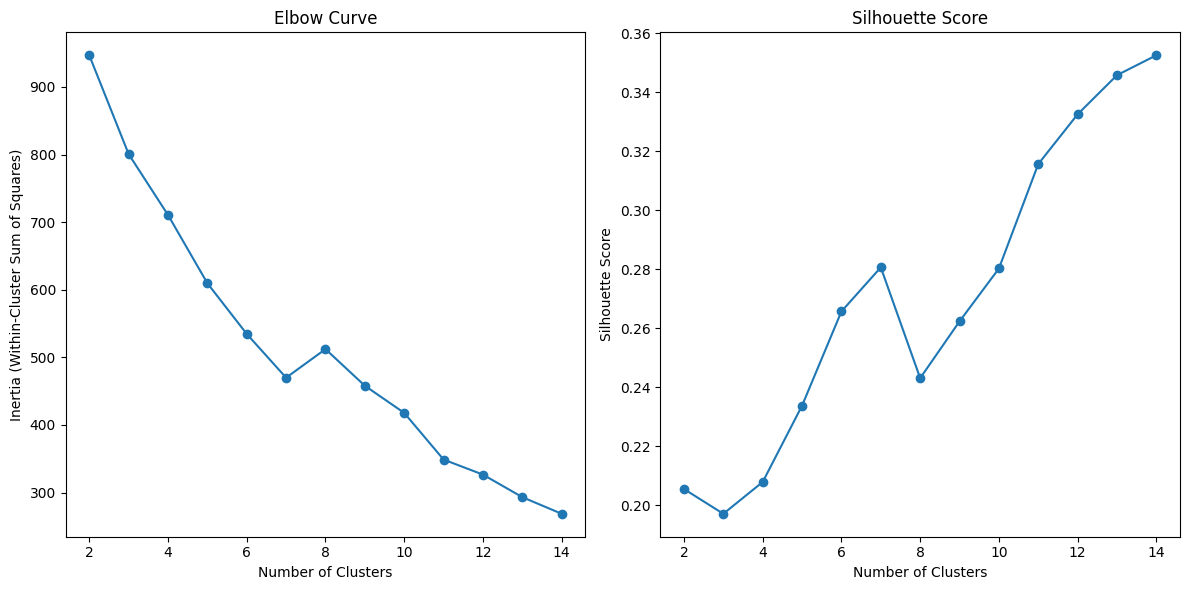

Optimal number of clusters: 14


In [34]:

# Plot the elbow curve to find the optimal number of clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')

# Plot the silhouette score to evaluate cluster quality
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Based on the plots, you can choose the optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

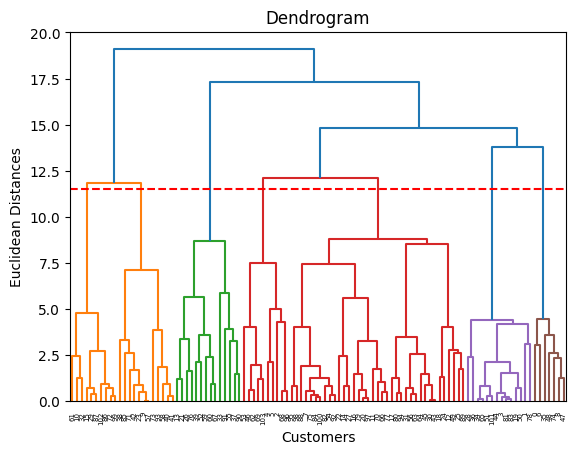

In [35]:
# Using the dendogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=11.5, color='r', linestyle='--')
plt.show()

No. of Clusters = 7

In [36]:
# Fitting hierarchial clustering
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=7,linkage='ward')
features_df['Cluster'] = hc.fit_predict(X)


In [37]:
results_df = features_df[selected_features+['Cluster']]
results_df.head()

,asian,biryani,chinese,continental,desserts,fastfood,italian,northindian,southindian,Cost,Avg_Rating,Cluster
Name,,,,,,,,,,,,
Beyond Flavours,0,0,1,1,0,0,0,1,1,800,4.28,3
Paradise,0,1,1,0,0,0,0,1,0,800,4.70,4
Flechazo,1,0,0,0,1,0,0,1,0,1300,4.66,5
Shah Ghouse Hotel & Restaurant,0,1,1,0,0,0,0,1,0,800,3.21,4
Over The Moon Brew Company,1,0,1,1,0,0,0,1,0,1200,4.34,5


In [38]:
# lets observe the data for clusters 
results_df_grouped = results_df.groupby('Cluster').sum()
results_df_grouped[['Cost','Avg_Rating']] = results_df[['Cost','Avg_Rating','Cluster']].groupby('Cluster').mean()
results_df_grouped.head(10)

,asian,biryani,chinese,continental,desserts,fastfood,italian,northindian,southindian,Cost,Avg_Rating
Cluster,,,,,,,,,,,
0,0,0,15,6,0,0,0,23,0,847.297297,3.626070
1,0,1,0,1,12,5,0,0,0,508.333333,3.614524
2,5,0,5,9,0,0,14,11,1,1532.142857,3.776429
3,0,1,5,2,0,0,0,7,7,671.428571,3.628571
4,0,14,12,1,0,0,0,13,0,650.000000,3.401701
5,10,0,5,2,1,0,0,3,0,1190.000000,3.853478
6,0,0,1,0,0,10,0,3,0,495.000000,3.292929


Cuisine Distribution Across clusters & Price/Ratings comparision

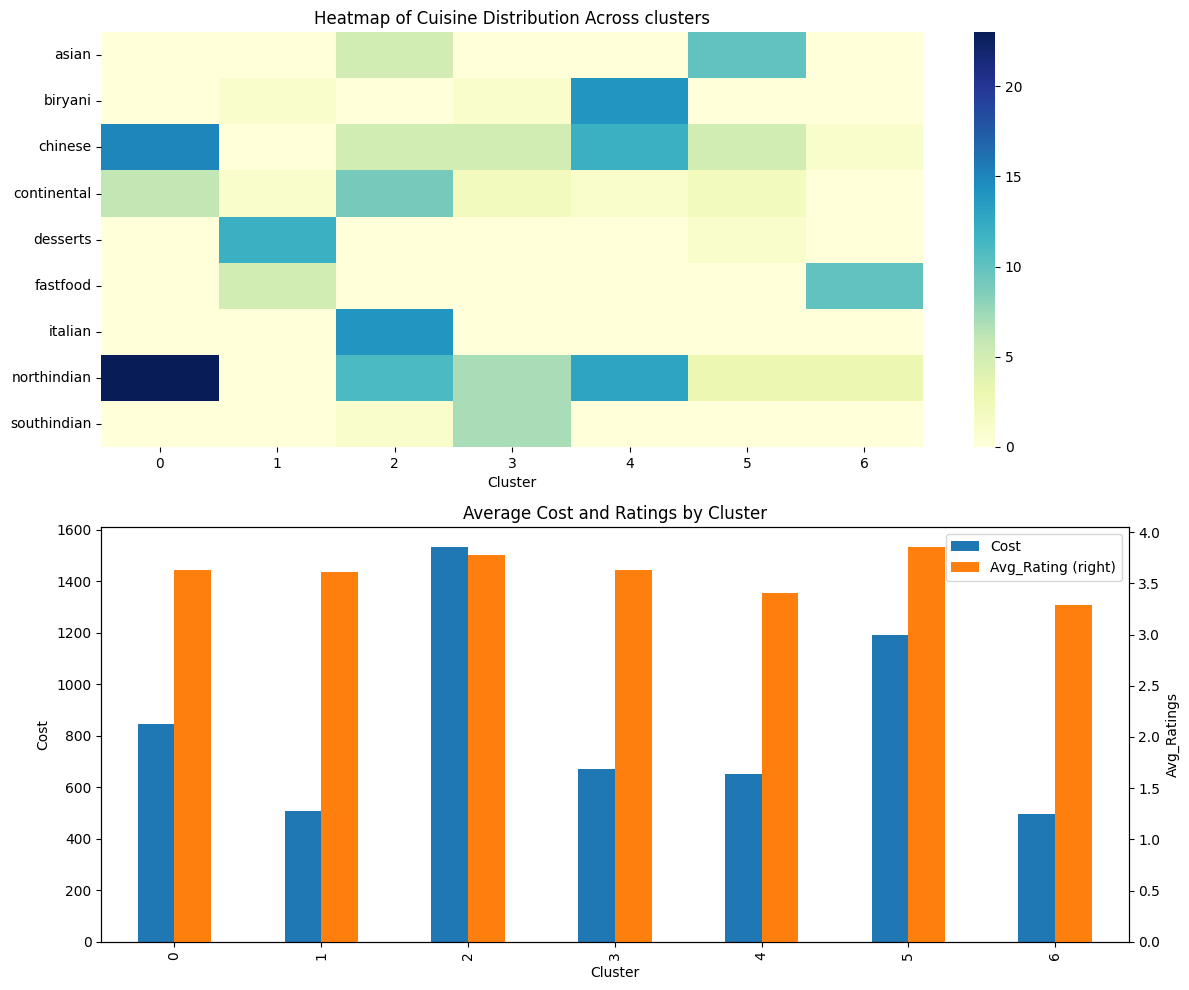

In [40]:
cuisine_data = results_df_grouped.drop(['Cost','Avg_Rating'],axis=1)
cost_ratings = results_df_grouped[['Cost','Avg_Rating']]

fig, ax = plt.subplots(2,1,figsize=(12,10))

sns.heatmap(cuisine_data.T,ax=ax[0],cmap="YlGnBu")
ax[0].set_title('Heatmap of Cuisine Distribution Across clusters')

cost_ratings.plot(kind='bar',ax=ax[1],secondary_y='Avg_Rating')
ax[1].set_title('Average Cost and Ratings by Cluster')
ax[1].set_ylabel('Cost')
ax[1].right_ax.set_ylabel('Avg_Ratings')

plt.tight_layout()
plt.show()

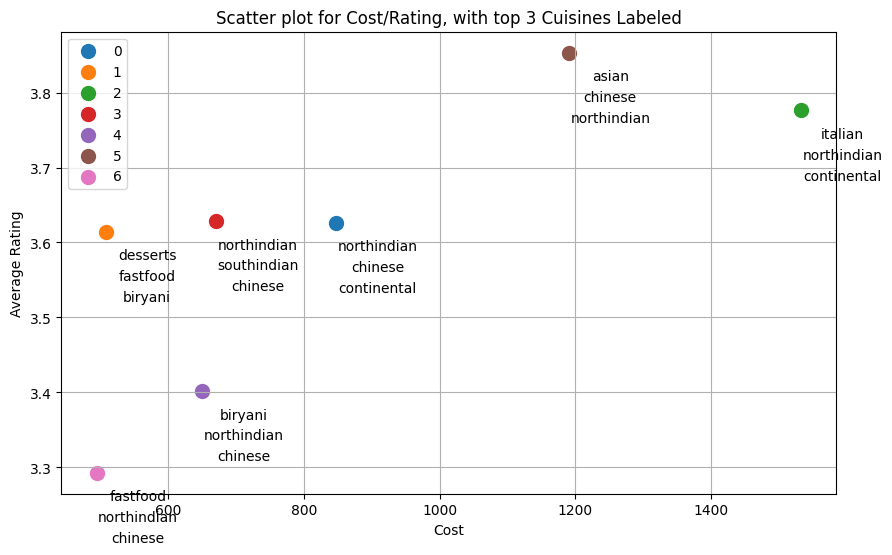

In [48]:
df = results_df_grouped.reset_index()

plt.figure(figsize=(10,6))

for i, row in df.iterrows():
    plt.scatter(row['Cost'],row['Avg_Rating'], s=100, label=f"{int(row['Cluster'])}")
    top_cuisines = row.drop(['Cluster','Cost','Avg_Rating']).nlargest(3)
    index = 0
    for cuisine, value in top_cuisines.items():
        if value > 0:
            plt.annotate(cuisine,(row['Cost'],row['Avg_Rating']), textcoords="offset points", xytext=(30,-20-index*15),ha='center')
            index += 1

plt.xlabel('Cost')
plt.ylabel('Average Rating')
plt.title('Scatter plot for Cost/Rating, with top 3 Cuisines Labeled')
plt.legend()
plt.grid(True)
plt.show()


Rating to Cost Ratio

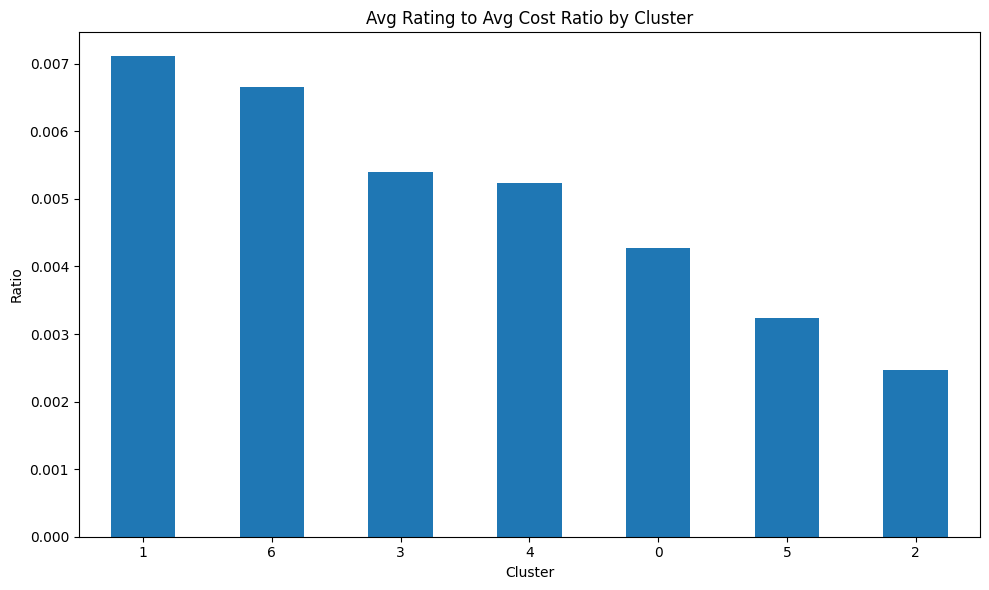

In [43]:
(cost_ratings.Avg_Rating/cost_ratings.Cost).sort_values(ascending=False).plot(kind='bar',figsize=(10,6))

plt.title('Avg Rating to Avg Cost Ratio by Cluster')
plt.ylabel('Ratio')
plt.xlabel('Cluster')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Cluster Analysis Conclusion:

1) Cluster 0: has a moderate cost and ratings, and a descent ratio of ratings to cost. This cluster has variety of cuisines, such as north-indian, chinese, continental these restaurants are medium rated restaurants with medium to higher cost.

2) Cluster 1: has the best cost and rating among all the clusters, and a high ratio of rating to cost. These are mostly fastfood chains serving desserts, fastfood, biryani which offer a good balance of quality, price, and diversity. These restaurants attract a lot of customers in bulk, due to the factor of best ratings to cost ratio.

3) Cluster 2: these restaurants have lowest ratings/cost, they have a descent rating but high cost, reason given the ambience or place might be luxurious but the food is descent w.r.t cost.

4) Cluster 3: these restaurants have good rating/cost, these restaurants serve indian food from north as well as south. These serve good quality food for the given cost, customers often come here when they want descent indian food.

5) Cluster 4: this is similar to cluster 3, the main difference is what they are trying to serve (biryani, northindian, chinese) they have lower rating probably due to cleanliness. 

6) Cluster 5: these are high rated restaurants, falling under luxury category, the common customers are corporate or rich people.

7) Cluster 6: these are small restaurants which serve fastfood and chinese food, they have less rating compared to others due to cleanliness, but have huge customers visiting due to lowest price and also the food served is a snack.
